In [2]:
pip install konlpy

     |████████████████████████████████| 19.4 MB 5.5 MB/s 
     |████████████████████████████████| 448 kB 46.5 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
from google.colab import files
uploaded = files.upload()

Saving ratings_train.txt to ratings_train.txt


In [5]:
from google.colab import files
uploaded = files.upload()

Saving ratings_test.txt to ratings_test.txt


In [6]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [7]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [8]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [9]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [10]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [11]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


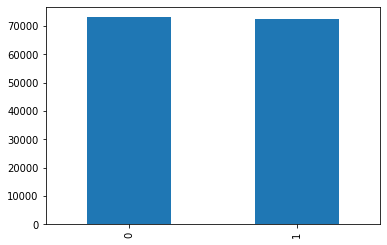

In [61]:
train_data['label'].value_counts().plot(kind = 'bar')

In [13]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [14]:
print(train_data.isnull().value_counts())

id     document  label
False  False     False    146182
       True      False         1
dtype: int64


In [15]:
# 어느 열에 눌값이 있는지 확인
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [16]:
# 어느 행에 눌값이 있는지 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [17]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [18]:
# 한글과 공백을 제외하고 모두 제거하는 정규표현식
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [19]:
# 정규표현식 적용후에도 눌값이 있는지 확인 => 789개 확인
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [20]:
# 눌값인 행 삭제
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [21]:
# 테스트 데이터에도 동일한 과정 진행
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


30000


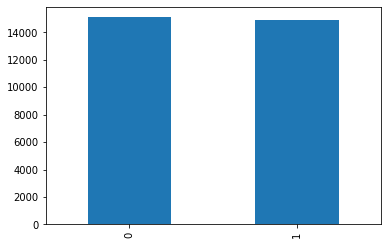

In [60]:
# 트레인데이터 3만개로 줄이기
train_data2 = train_data[:30000]
print(len(train_data2))
train_data2['label'].value_counts().plot(kind = 'bar')

In [28]:
# 테스트데이터 만개로 줄이기
test_data2 = test_data[:10000]
print(len(test_data2))

10000


In [23]:
#불용어 설정
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [24]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [29]:
#트레인 데이터 토큰화(okt 이용)
X_train = []
for sentence in tqdm(train_data2['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 30000/30000 [02:19<00:00, 215.17it/s]


In [30]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [32]:
#테스트 데이터 토큰화(okt 이용)
X_test = []
for sentence in tqdm(test_data2['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 10000/10000 [00:43<00:00, 230.06it/s]


In [35]:
# 정수인코딩 : 각 단어에 고유의 숫자 부여하기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '재밌다': 11, '만': 12, '되다': 13, '적': 14, '같다': 15, '진짜': 16, '로': 17, '않다': 18, '아니다': 19, '점': 20, '에서': 21, '만들다': 22, '연기': 23, '평점': 24, '것': 25, '나오다': 26, '최고': 27, '나': 28, '안': 29, '내': 30, '인': 31, '그': 32, '스토리': 33, '왜': 34, '못': 35, '생각': 36, '드라마': 37, '사람': 38, '게': 39, '보고': 40, '감동': 41, '이렇다': 42, '말': 43, '고': 44, '아깝다': 45, '더': 46, '때': 47, '감독': 48, 'ㅋㅋ': 49, '아': 50, '그냥': 51, '재미': 52, '거': 53, '재미있다': 54, '배우': 55, '시간': 56, '요': 57, '까지': 58, '하고': 59, '내용': 60, '중': 61, '자다': 62, '재미없다': 63, '뭐': 64, '지루하다': 65, '주다': 66, '네': 67, '모르다': 68, '쓰레기': 69, '가다': 70, '수': 71, '싶다': 72, '들다': 73, '작품': 74, '알다': 75, '지': 76, '하나': 77, '사랑': 78, '다시': 79, '그렇다': 80, '볼': 81, '정도': 82, '이건': 83, '마지막': 84, '저': 85, 'ㅋ': 86, '이렇게': 87, 'ㅋㅋㅋ': 88, '액션': 89, '완전': 90, 'ㅠㅠ': 91, '걸': 92, '많다': 93, '차다': 94, '돈': 95, '최악': 96, '처음': 97, '오다': 98, '장면': 99, '개': 100, '나다': 101, '안되다': 10

In [36]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 21238
등장 빈도가 2번 이하인 희귀 단어의 수: 12916
단어 집합에서 희귀 단어의 비율: 60.815519352104715
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.845473275966549


In [37]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 8323


In [38]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [39]:
print(X_train[:3])

[[50, 456, 16, 250, 661], [943, 417, 40, 640, 1, 181, 1542, 23, 990, 725, 18], [358, 2062, 2750, 3646, 2, 222, 9]]


In [41]:
y_train = np.array(train_data2['label'])
y_test = np.array(test_data2['label'])

In [42]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [43]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

29909
29909


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 63
리뷰의 평균 길이 : 10.500117021632285


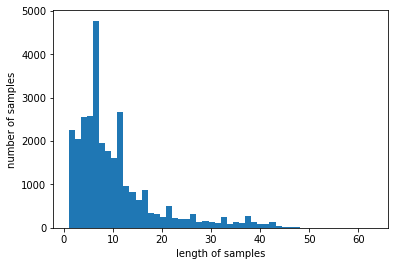

In [44]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [45]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [51]:
max_len_long = 60
below_threshold_len(max_len_long, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99665652479187


In [50]:
max_len_short = 20
below_threshold_len(max_len_short, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 88.33795847403792


In [52]:
X_train = pad_sequences(X_train, maxlen=max_len_long)
X_test = pad_sequences(X_test, maxlen=max_len_long)

X_train2 = pad_sequences(X_train, maxlen=max_len_short)
X_test2 = pad_sequences(X_test, maxlen=max_len_short)

In [53]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=3, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/3
374/374 [==============================] - ETA: 0s - loss: 0.4560 - acc: 0.7839
Epoch 1: val_acc improved from -inf to 0.82280, saving model to best_model.h5
374/374 [==============================] - 69s 169ms/step - loss: 0.4560 - acc: 0.7839 - val_loss: 0.3981 - val_acc: 0.8228
Epoch 2/3
374/374 [==============================] - ETA: 0s - loss: 0.3475 - acc: 0.8480
Epoch 2: val_acc improved from 0.82280 to 0.82447, saving model to best_model.h5
374/374 [==============================] - 58s 155ms/step - loss: 0.3475 - acc: 0.8480 - val_loss: 0.3850 - val_acc: 0.8245
Epoch 3/3
374/374 [==============================] - ETA: 0s - loss: 0.3202 - acc: 0.8626
Epoch 3: val_acc improved from 0.82447 to 0.83149, saving model to best_model.h5
374/374 [==============================] - 58s 156ms/step - loss: 0.3202 - acc: 0.8626 - val_loss: 0.3864 - val_acc: 0.8315


In [54]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

313/313 [==============================] - 10s 27ms/step - loss: 0.3921 - acc: 0.8307

 테스트 정확도: 0.8307
